In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import os
import re
import io
import ast
import sys
import json
import boto3 
import pymongo 
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import cm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D


from PIL import Image
from urllib import request
from collections import Counter

sys.path.append("../")
import cabutils

In [3]:
sns.set_style("darkgrid")
sns.set_context("notebook")

In [4]:
from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [162]:
projName = "mlve"
experiment = "tdw"
experimentName = f"{experiment}_surface-normals"
S3_BUCKET_NAME = "mlve-v1"

To download data (@Yoni only), run: 
ssh -i /Users/yoni/Desktop/cocosci_pem/Cocosci_WebExperiments.pem -nNL 8000:localhost:27017  ubuntu@ec2-3-90-78-57.compute-1.amazonaws.com

# Downloading data from ec2 server (mostly just instructions for thomas)

In `settings.conf` change the `MONGODB_PORT` to 8000, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/pem/key/maybe-named-something-like/Cocosci_WebExperiments.pem -fNL 8000:localhost:27017 ubuntu@ec2-54-91-252-25.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [163]:
conn = cabutils.get_db_connection()
db = conn[projName + "_outputs"]
col = db[experimentName]

Checking database connection...
Connection established!


In [164]:
def results_to_df():
    results = []
    cursor = col.find({})
    for document in cursor:
        results.append(document)
    
    df = pd.DataFrame(results)
    return df

df = results_to_df()

In [165]:
for i, x in df[df["trial_type"] == "survey-text"].iterrows():
    print(x["response"])

{'TechnicalDifficultiesFreeResp': '', 'participantComments': ''}
{'TechnicalDifficultiesFreeResp': 'Sometimes i click outside when the pointer was black and turn red again', 'participantComments': 'It was very funny'}
{'TechnicalDifficultiesFreeResp': 'I did not encounter dificulties', 'participantComments': 'It was indeed fun'}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': 'The study was very entertaining and the practice trials helped a lot. '}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': ''}
{'TechnicalDifficultiesFreeResp': 'none', 'participantComments': ''}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': ''}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': ''}
{'TechnicalDifficultiesFreeResp': 'Sometimes it was hard to understand exactly where the pointer was and what object it was attached to', 'participantComments': ''}
{'TechnicalDifficultiesFreeResp': '', 'participantComments': ''}
{'TechnicalDifficultiesFreeResp': '', 'p

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3977 entries, 0 to 3976
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             3977 non-null   object 
 1   trueArrowDirection              3947 non-null   object 
 2   imageURL                        3947 non-null   object 
 3   is_duplicate                    3947 non-null   object 
 4   randomizeArrowInitialDirection  3947 non-null   object 
 5   arrowPixelPosition              3947 non-null   object 
 6   attention_check                 3947 non-null   object 
 7   arrowPosition                   3947 non-null   object 
 8   trialType                       3947 non-null   object 
 9   batch_idx                       3758 non-null   float64
 10  meta                            3758 non-null   object 
 11  indicatorFinalDirection         3947 non-null   object 
 12  indicatorDirectionTrajectory    39

In [167]:
df.drop("trial_type", axis=1, inplace=True)
df.drop("rt", axis=1, inplace=True)
df.drop("response", axis=1, inplace=True)
df.drop("inputid", axis=1, inplace=True)

In [168]:
df.drop(df[df["indicatorFinalDirection"].isna() == True].index, inplace=True)

In [169]:
df.drop(df[df["trueArrowDirection"].apply(lambda x: x == [None, None, None]) == True].index, inplace=True)

In [170]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [171]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [172]:
def draw_circles(ax, locs, size=10, edgecolor="red", facecolor="none", lw=2):
    """
    draws circle patches on an image at specified locations
    """
    for point in locs:
        circ = patches.Circle((point[1], point[0]), size, ec=edgecolor, fc=facecolor, lw=lw)
        ax.add_patch(circ)
    return ax


In [173]:
def cos_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [174]:
def geodesic_dist(a, b):
    a = np.array(a)
    b = np.array(b)
    if not a.shape or not b.shape:
        print("No data for: ", a, b)
        return float("nan")

    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    
    dist = np.arccos(a.dot(b))
    return dist

### Check user consistency

In [176]:
potential_fails = []
for user, rows in df.groupby("userID"):
    attention_checks = rows[rows["attention_check"]]
    ifd = attention_checks["indicatorFinalDirection"].values
    tad = attention_checks["trueArrowDirection"].values
    
    dists = [geodesic_dist(a, b) for a, b in zip(ifd, tad)]
    score = np.mean(dists)
    if score > 1:
        print(user, score)
        potential_fails.append(user)
print(potential_fails)

5ed6d094c1fe3d143fb81423 2.033397476541365
60df94355f967da1e722016b 1.6354097433456347
611cc87fae0fb55e133eca3d 1.6410004360042205
613a59b4554295dbdaa5dc24 1.6193193060917184
6148bb7a4e102e94773dcc5c 1.2423487952047243
616ec4d19fc1b4726c15d3ab 1.318893090918351
['5ed6d094c1fe3d143fb81423', '60df94355f967da1e722016b', '611cc87fae0fb55e133eca3d', '613a59b4554295dbdaa5dc24', '6148bb7a4e102e94773dcc5c', '616ec4d19fc1b4726c15d3ab']


In [183]:
userID = "611cc87fae0fb55e133eca3d"
print(len(df[df["userID"] == userID]))
print(df[df["userID"] == userID]["geodesic_distance"].median())

125
1.449288620355341


In [175]:
df["geodesic_distance"] = df.apply(lambda x: geodesic_dist(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)
df["cosine_similarity"] = df.apply(lambda x: cos_similarity(x["indicatorFinalDirection"], x["trueArrowDirection"]), axis=1)

In [ ]:
df[df["userID"] == "5dafea4de40355001651fa2f"]["geodesic_distance"]

In [100]:
for user in potential_fails:
    print(df[df["userID"] == user]["geodesic_distance"].mean(), user)

1.199190417084332 5dafea4de40355001651fa2f
1.0978555948132995 5db35c6cd14d3d000a07f3f6
1.190581961759894 616093ab4117242c856402c6


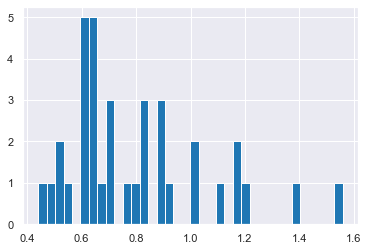

In [133]:
geo_errors = []
n_users = 0
for user, rows in df.groupby("userID"):
    geo_errors.append(rows["geodesic_distance"].mean())
    n_users += 1
    
plt.hist(geo_errors, bins=n_users )
plt.show()
    

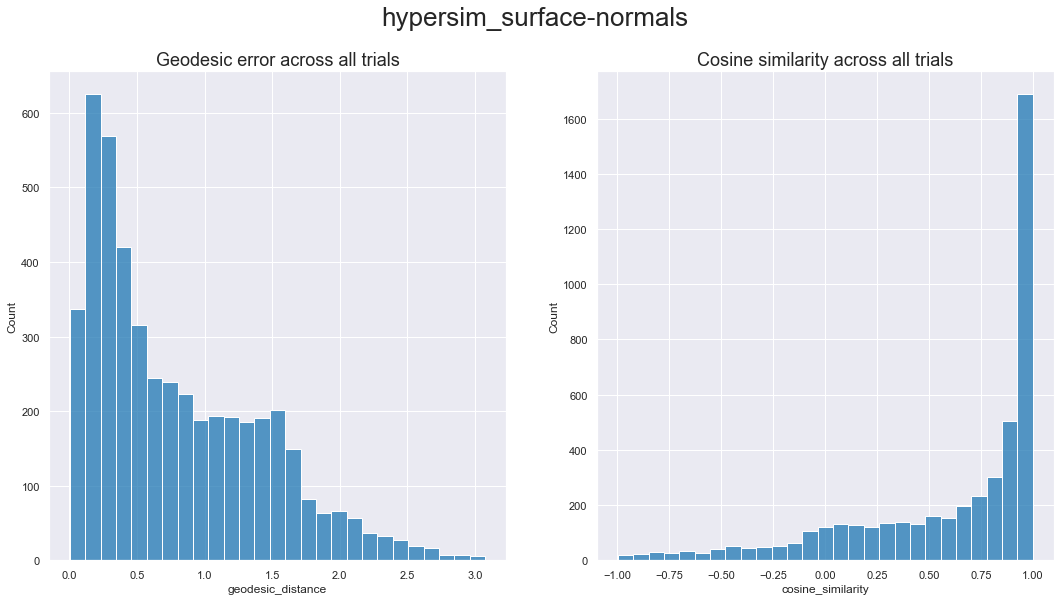

In [91]:

fig, axs = plt.subplots(1, 2, figsize=(18,9))
sns.histplot(df["geodesic_distance"], ax=axs[0])
sns.histplot(df["cosine_similarity"], ax=axs[1])

axs[0].set_title(f"Geodesic error across all trials", fontsize=18)
axs[1].set_title(f"Cosine similarity across all trials", fontsize=18)
plt.suptitle(f"{experimentName}")

plt.show()

# Generate cleaned version

In [92]:
df.head()

_id  \
0  62bca051d72a4a05052b3850   
1  62bca05dd72a4a05052b385b   
2  62bca068d72a4a05052b386b   
3  62bca074d72a4a05052b387a   
4  62bca079d72a4a05052b387f   

                                  trueArrowDirection  \
0   [0.53173828125, -0.2364501953125, 0.81298828125]   
1  [0.494873046875, -0.1802978515625, 0.85009765625]   
2   [-0.1676025390625, 0.84716796875, 0.50439453125]   
3  [0.0190582275390625, -0.86083984375, 0.5087890...   
4  [-0.69287109375, -0.03887939453125, 0.7197265625]   

                                            imageURL is_duplicate  \
0  https://mlve-v1.s3.us-east-2.amazonaws.com/hyp...        False   
1  https://mlve-v1.s3.us-east-2.amazonaws.com/hyp...        False   
2  https://mlve-v1.s3.us-east-2.amazonaws.com/hyp...        False   
3  https://mlve-v1.s3.us-east-2.amazonaws.com/hyp...        False   
4  https://mlve-v1.s3.us-east-2.amazonaws.com/hyp...        False   

  randomizeArrowInitialDirection arrowPixelPosition attention_check  \
0                           True         [432, 220]           False   
1                           True           [329, 2]           False   
2                           True         [392, 337]           False   
3                           True          [351, 41]           False   
4                           True         [105, 501]           False   

                                 arrowPosition     trialType  batch_idx  ...  \
0  [-0.7113894324853227, 3.536908023483366, 0]  unsupervised        2.0  ...   
1   [-5.079921722113503, 1.472876712328767, 0]  unsupervised        2.0  ...   
2  [1.6331898238747558, 2.7353424657534244, 0]  unsupervised        2.0  ...   
3   [-4.29839530332681, 1.9137377690802353, 0]  unsupervised        2.0  ...   
4   [4.919608610567514, -3.015890410958904, 0]  unsupervised        4.0  ...   

  internal_node_id                                     gameid iterationName  \
0         0.0-12.0  6665-e7037dcd-324a-4cc7-8e32-e333d02ff15a            v2   
1         0.0-13.0  6665-e7037dcd-324a-4cc7-8e32-e333d02ff15a            v2   
2         0.0-14.0  6665-e7037dcd-324a-4cc7-8e32-e333d02ff15a            v2   
3         0.0-15.0  6665-e7037dcd-324a-4cc7-8e32-e333d02ff15a            v2   
4         0.0-12.0  2494-f172d4e0-2720-4e16-a322-add3ffe6cf6f            v2   

  projName                   expName                 sessionID  \
0     mlve  hypersim_surface-normals  62bc9e6196b0a1efe8054087   
1     mlve  hypersim_surface-normals  62bc9e6196b0a1efe8054087   
2     mlve  hypersim_surface-normals  62bc9e6196b0a1efe8054087   
3     mlve  hypersim_surface-normals  62bc9e6196b0a1efe8054087   
4     mlve  hypersim_surface-normals  62bc99146541e6ff49c27638   

                    studyID                    userID  geodesic_distance  \
0  62bc98cb944f8dc069201cf7  5f1b2fe23bcef80c38d2a362           0.393555   
1  62bc98cb944f8dc069201cf7  5f1b2fe23bcef80c38d2a362           0.176105   
2  62bc98cb944f8dc069201cf7  5f1b2fe23bcef80c38d2a362           0.429653   
3  62bc98cb944f8dc069201cf7  5f1b2fe23bcef80c38d2a362           1.056951   
4  62bc98cb944f8dc069201cf7  5f2ed914a87abd287ed66ddf           2.023933   

  cosine_similarity  
0          0.923552  
1          0.984534  
2          0.909110  
3          0.491529  
4         -0.437787  

[5 rows x 29 columns]

In [101]:
participants = df.groupby("userID")
participants_failed = []
i = 0 
batch_idxs = []
for index, user_results in participants:
    i += 1
    batch_idxs.append(user_results.iloc[0]["batch_idx"])
    
    if len(user_results) < 100:
        print("USER ID: " + user_results["userID"].iloc[0] + " did not finish the experiment")
        participants_failed.append(user_results["userID"].iloc[0])
        continue
    
    if user_results["geodesic_distance"].mean() > 1.5:
        print("USER ID: " + user_results["userID"].iloc[0] + " did not do too well")
        continue
        
    attention_checks = user_results[user_results["attention_check"]] == True
    attention_score = attention_checks["geodesic_distance"].mean()
    if attention_score > 1:
        print("USER ID: " + user_results["userID"].iloc[0] + "scored: " + attention_score)
        participants_failed.append(user_results["userID"].iloc[0])

print(participants_failed)

# failed_participants = df["userID"].apply(lambda x: x in participants_failed)
# df = df[~failed_participants]
# attention_checks = df["stimulus"].apply(lambda x: "ground_truth" in x)
# df = df[~attention_checks]

# my_data = df["userID"] == "yoni_test2"
# df = df[~my_data]

USER ID: 5c48be0496d59b000183e68d did not do too well
[]


In [102]:
attention_indexes = df[df["attention_check"] == True].index
df.drop(attention_indexes, axis=0, inplace=True)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4466 entries, 0 to 4731
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _id                             4466 non-null   object 
 1   trueArrowDirection              4466 non-null   object 
 2   imageURL                        4466 non-null   object 
 3   is_duplicate                    4466 non-null   object 
 4   randomizeArrowInitialDirection  4466 non-null   object 
 5   arrowPixelPosition              4466 non-null   object 
 6   attention_check                 4466 non-null   object 
 7   arrowPosition                   4466 non-null   object 
 8   trialType                       4466 non-null   object 
 9   batch_idx                       4466 non-null   float64
 10  meta                            4466 non-null   object 
 11  indicatorFinalDirection         4466 non-null   object 
 12  indicatorDirectionTrajectory    44

# To-Do:

2. Check consistency
3. Rank participants by score
4. Check which trials had the lowest score

## Visualization Ideas

4. Each image w/ probe locations --> put em in a zip
3. Heatmap on a sphere?
1. Download image -- overlay subject estimates with arrow
6. Correlate (X, Y) with estimate + error
5. NSD --> Check participant distribution (histogram, heatmap)
7. Surface normal UNet / model?

### long shot vis
1. Compare distribution of histograms across datasets

## Plot the distribution of surface normals

In [104]:
indicator_directions = np.array([x for x in df["indicatorFinalDirection"]])
true_directions = np.array([x for x in df["trueArrowDirection"]])

In [105]:
### from tqdm.notebook import tqdm

def near( p, pntList, d0 ):
    cnt=0
    for pj in pntList:
        dist=geodesic_dist(p, pj)
        if dist < d0:
            cnt += 1 - dist/d0
    return cnt


"""
https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
"""

def calculate_heatmap(pointList, threshold=0.1):

    u = np.linspace( 0, 2 * np.pi, 60)
    v = np.linspace( 0, np.pi, 60 )

    # create the sphere surface
    XX = 10 * np.outer( np.cos( u ), np.sin( v ) )
    YY = 10 * np.outer( np.sin( u ), np.sin( v ) )
    ZZ = 10 * np.outer( np.ones( np.size( u ) ), np.cos( v ) )

    pbar = tqdm(total = len(XX) * len(XX[0]))

    WW = XX.copy()
    for i in range( len( XX ) ):
        for j in range( len( XX[0] ) ):
            x = XX[ i, j ]
            y = YY[ i, j ]
            z = ZZ[ i, j ]
            dist = near(np.array( [x, y, z ] ), pointList, threshold)
            WW[ i, j ] = dist
            pbar.update(1)

    heatmap = WW / np.amax( WW )
    return heatmap, (XX, YY, ZZ)

In [106]:
participant_heatmap, spherical_coords = calculate_heatmap(indicator_directions)
if experimentName != "nsd_surface-normals":
    gt_heatmap, spherical_coords = calculate_heatmap(true_directions)

NameError: name 'tqdm' is not defined

Text(0.5, 0.98, 'hypersim_surface-normals')

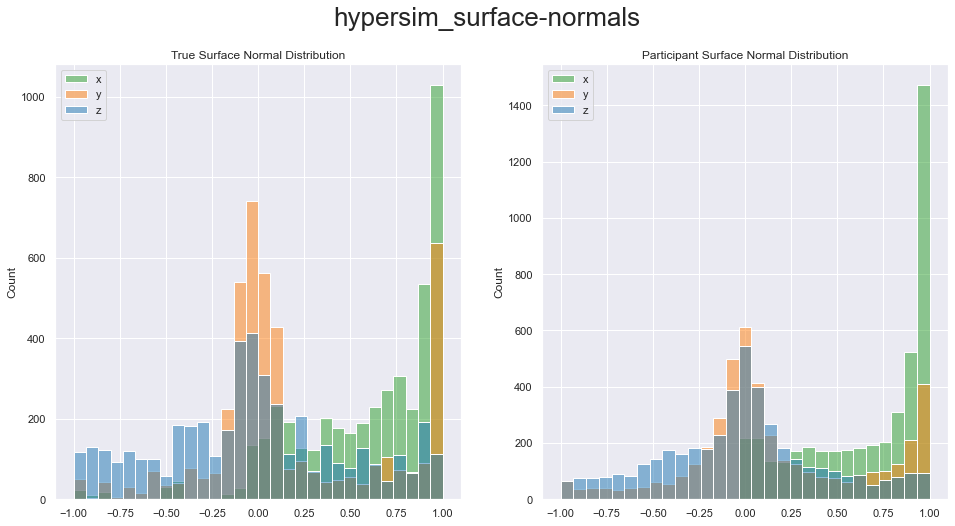

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
g = sns.histplot(true_directions, ax=axs[0])
axs[0].legend(["x","y","z"])
axs[0].set_title("True Surface Normal Distribution")

g = sns.histplot(indicator_directions, ax=axs[1])
axs[1].legend(["x","y","z"])
axs[1].set_title("Participant Surface Normal Distribution")
plt.suptitle(f"{experimentName}")

## Visualize the distribution of sampled points on images

In [108]:
plot_images = False

In [109]:
if plot_images:
    save_dir = os.path.join(f"figures/{experimentName}")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    sns.set_style("white")
    for url, row in df.groupby("imageURL"):
        point_locs = row["arrowPixelPosition"]
        locs = set()
        for point in point_locs:
            locs.add(tuple(point))

        locs = list(locs)
        image = download_from_url(url)
        plt.close()
        fig,ax = plt.subplots(1, figsize=(12, 12))
        ax.set_aspect('equal')

        ax = draw_circles(ax, locs, size=15, lw=4)
        ax = draw_circles(ax, locs, size=10, lw=4)

        ax.imshow(image)
    #     pixelPositions = row["arrowPixelPosition"]
    #     idfs = row["indicatorFinalDirection"]
    #     for i in range(len(pixelPositions)):
    #         loc = pixelPositions.iloc[i]
    #         ifd = idfs.iloc[i]
    #         r = lambda: np.random.randint(0,255)
    #         color = '#%02X%02X%02X' % (r(),r(),r())
    #         ax.quiver(loc[1], loc[0], ifd[0], ifd[2], scale=ifd[1], color=color, angles="xy", scale_units='y')

        save_title = url.split("/")[-1]
        plt.savefig(os.path.join(save_dir, save_title))
        plt.show()


    sns.set_style("darkgrid")   

In [110]:
indicator_directions.shape, heatmap.shape

NameError: name 'heatmap' is not defined

In [111]:

fig = go.Figure(data=[go.Scatter3d(x=spherical_coords[0].flatten(), 
                                   y=spherical_coords[1].flatten(), 
                                   z=spherical_coords[2].flatten(),
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=participant_heatmap.flatten(),                # set color to an array/list of desired values
                                    colorscale='inferno',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})

fig.show()


NameError: name 'spherical_coords' is not defined

In [112]:

fig = go.Figure(data=[go.Scatter3d(x=spherical_coords[0].flatten(), 
                                   y=spherical_coords[1].flatten(), 
                                   z=spherical_coords[2].flatten(),
                                   mode='markers',
                                   marker=dict(
                                    size=3,
                                    color=gt_heatmap.flatten() + np.random.random(3600),                # set color to an array/list of desired values
                                    colorscale='inferno',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})

fig.show()


NameError: name 'spherical_coords' is not defined

[[1.        0.3150981]
 [0.3150981 1.       ]]
[[1.         0.32200709]
 [0.32200709 1.        ]]
[[1.         0.20093791]
 [0.20093791 1.        ]]


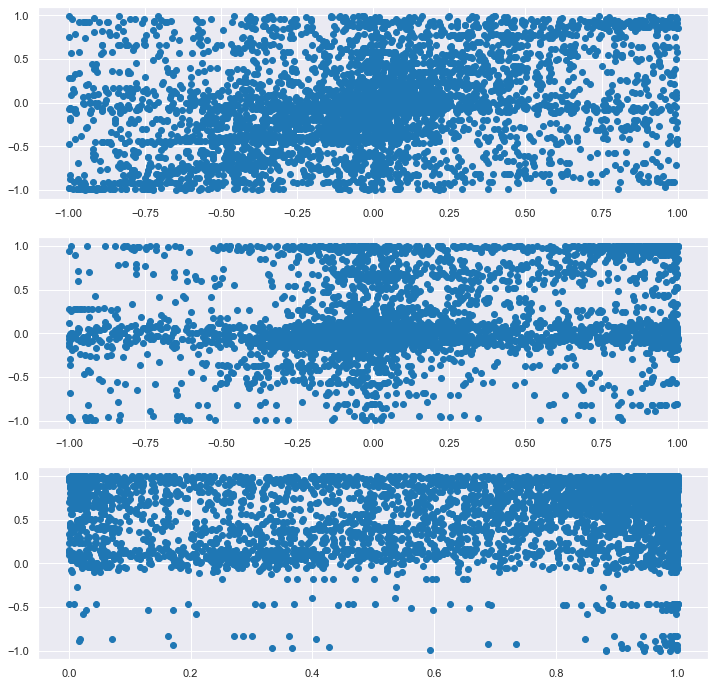

In [128]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
for i in range(3):
    axs[i].scatter(indicator_directions[:, i], true_directions[:, i])
    print(np.corrcoef(indicator_directions[:, i], true_directions[:, i]))
plt.show()


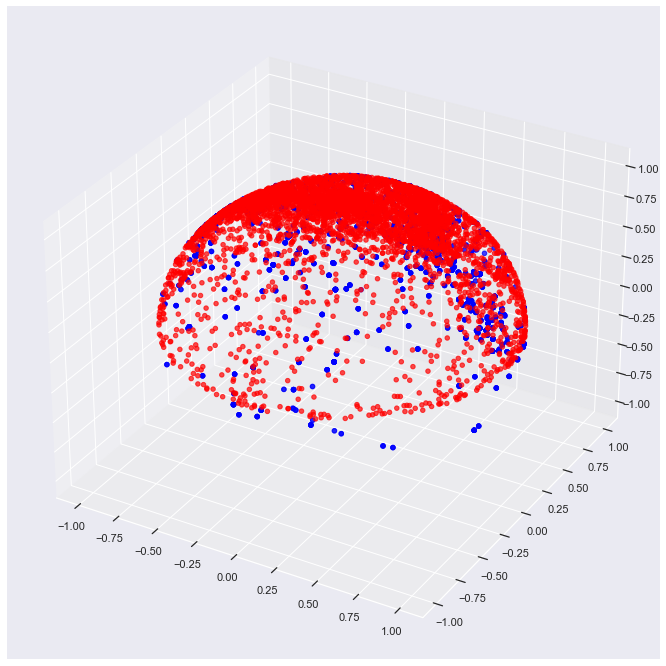

In [123]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(projection='3d')

ax.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2], color="red", alpha=0.7)
ax.scatter(true_directions[:, 0], true_directions[:, 1], true_directions[:, 2], color="blue")

plt.show()

In [120]:

fig = go.Figure(data=[go.Scatter3d(x=indicator_directions[:, 0], 
                                   y=indicator_directions[:, 1], 
                                   z=indicator_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    color="blue",
                                    size=5,
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})
fig.show()

fig = go.Figure(data=[go.Scatter3d(x=indicator_directions[:, 0], 
                                   y=indicator_directions[:, 1], 
                                   z=indicator_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    color="red",
                                    size=5,
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})



fig.show()


In [114]:

fig = go.Figure(data=[go.Scatter3d(x=true_directions[:, 0], 
                                   y=true_directions[:, 1], 
                                   z=true_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=true_directions[:, 0],                # set color to an array/list of desired values
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])

fig.update_layout({"title": f"{experimentName}: True Surface Normal Distribution"})
fig.show()

NameError: name 'XX' is not defined

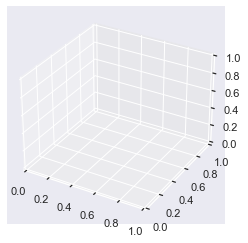

In [115]:
fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1, projection='3d')

ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( heatmap ) )
plt.show() 


In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=true_directions[:, 0], 
                                   y=true_directions[:, 1], 
                                   z=true_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=heatmap,                # set color to an array/list of desired values
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])

fig.update_layout({"title": f"{experimentName}: True Surface Normal Distribution"})
fig.show()

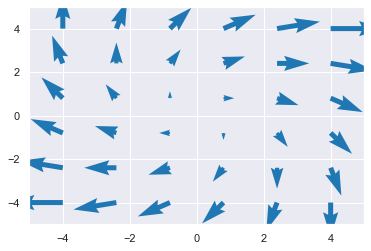

In [116]:
x = np.linspace(-4, 4, 6)
y = np.linspace(-4, 4, 6)
X, Y = np.meshgrid(x, y)
U = X + Y
V = Y - X

# plot
fig, ax = plt.subplots()

ax.quiver(X, Y, U, V, color="C0", angles='xy',
          scale_units='xy', scale=5, width=.015)

ax.set(xlim=(-5, 5), ylim=(-5, 5))

plt.show()